
- Applying model and Gridsearch


In [1]:
import glob
from os import getcwd
import os
import pickle 
import pandas as pd
import numpy as np
import datetime
import random
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow_addons.metrics import RSquare
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Dropout

In [4]:
# get working directory
path = os.path.dirname(getcwd())
os.chdir(path)

In [5]:
# get working directory

with open("data/full_features/f-regression/testdt.pkl", 'rb') as f:
   _, ytest_df =  pickle.load(file = f)
with open("data/full_features/f-regression/traindt-tf.pkl", 'rb') as f:
   xtrain, ytrain =  pickle.load(file = f)
with open("data/full_features/f-regression/testdt-tf.pkl", 'rb') as f:
   xtest, ytest =  pickle.load(file = f)

In [6]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape, ytest_df.shape

((738, 52), (104, 52), (738,), (104,), (104, 1))

Set up experiment, Spliting data


In [7]:
import logging
import random
logging.getLogger('tensorflow').disabled = True 
seed = 12345

In [8]:
# spliting data to visualize chosen networks
random.seed(seed)
xtrain_, xval_, ytrain_, yval_ = train_test_split(xtrain, ytrain, test_size=0.20, random_state=42)

In [9]:
xval_.shape, yval_.shape

((148, 52), (148,))

In [10]:
xtrain_.shape, ytrain_.shape

((590, 52), (590,))

Get measure functions, summary Grid results


In [11]:
def summaryGridresult(grid_result, tablename, printrow=6):
   print(tablename)
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   res_tab = pd.DataFrame(grid_result.cv_results_).sort_values(by=['mean_test_score'], ascending=False)
   res_tab = res_tab[['params','mean_train_score','std_test_score','mean_test_score','std_test_score']]
   return res_tab[:printrow]

## Model implementation


### Neural Networks


In [12]:
# Building plot function 

def plot_history(model_hist, expname, epochs =200):
    res = pd.DataFrame(model_hist.history)
    res_dic = {'loss - MSE':{'train':res['loss'], 'val':res['val_loss']},
                'r2': {'train':res['r_square'], 'val':res['val_r_square']}}
    x = range(1, epochs+1)
    fig, ax = plt.subplots(ncols = 2, figsize = [15,5])
    measures = list(res_dic.keys())
    for i, m in enumerate(measures):
        ax[i].plot(x, res_dic[m]['train'], label = f'training{m}')
        ax[i].plot(x, res_dic[m]['val'], label = f'training{m}')
        ax[i].set_ylabel(measures[i])   
        ax[i].set_title(f'Training and validation {m} {expname}')
        ax[i].legend(['training', 'validation'])
        ax[i].grid(visible=True)
    plt.xlabel('Epochs')
    plt.show()

In [13]:
#plot comparation

def plot_comparation(data_list, label_list, title, ylabel, epochrange):
    epochs = range(epochrange[0]+1, epochrange[1]+1)
    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data[epochrange[0]: epochrange[1]], label=label)
    plt.title(title)
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [14]:
# Plot prediction
%matplotlib inline
def plotprediction(true, pred, modelname):
    pred_table = pd.DataFrame({'preds': pred}, index = true.index)
    prediction_table = true.join(pred_table)
    prediction_table = prediction_table.rename(columns = {'sales': 'true'})
    
    fig, ax = plt.subplots(figsize=(20,5))
    ax.plot(prediction_table['true'], label='Truth')
    ax.plot(prediction_table['preds'], label='Prediction')
    ax.set_title('Comparing prediction from {}'.format(modelname), fontsize=20)
    ax.set_xlabel('Time', fontsize=16)
    ax.set_ylabel('Sales', fontsize=16)
    
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(8)
    leg = ax.legend(fontsize = 18)

In [15]:
def get_best_epochs(model_hist):
   model_loss = model_hist.history["val_loss"]
   epoch_chosen = model_loss.index(min(model_loss)) +1
   print(f'Best number of epochs {epoch_chosen}')

In [16]:
# precision
def get_pre(true, pred,threshold = 0.1): # the difference is not bigger than 3
    TP = 0
    for i in range(len(true)):
        if true[i] == 0:
            if abs(true[i]-pred[i]) <= 3:
                TP +=1 
        else:
            if abs(true[i]-pred[i])/true[i] <= threshold:
                TP +=1
    return TP/len(true)

MLP


In [17]:
# Finding the best Number of hidden layers
mlp_gridlayers = {'hidden_layer_sizes': [(64, 8),
                                         (64, 16, 8),
                                         (128, 16, 8),
                                         (128, 32, 8),
                                         (128, 64, 8),
                                         (128, 64, 16),
                                         (128, 64, 16, 8),
                                         (256, 128, 16, 8),
                                         (256, 128, 32, 8),
                                         (256, 128, 64, 8),
                                         (256, 128, 64, 16),
                                         (256, 128, 64, 32),
                                         (128, 128, 128, 64, 16),
                                         (256, 128, 128, 64, 8),
                                         (256, 256, 128, 128, 64),
                                         (256, 128, 64, 16, 8),
                                         (256, 128, 64, 32, 8),
                                         (256, 128, 64, 32, 16),
                                         (256, 128, 64, 64, 8),
                                         (256, 128, 64, 64, 16),
                                         (256, 128, 64, 32, 16, 8),]}

random.seed(seed)
mlp = MLPRegressor(max_iter=200, early_stopping=True)  # default by the rest
grid_layers = GridSearchCV(mlp, mlp_gridlayers, cv=4,
                           scoring='r2',
                           return_train_score=True,
                           n_jobs=-1)
grid_result_layer = grid_layers.fit(xtrain, ytrain)


In [18]:
summaryGridresult(grid_result_layer, 'Best results for Hidden layers structures', 10)

Best results for Hidden layers structures
Best: 0.666449 using {'hidden_layer_sizes': (256, 128, 32, 8)}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
8,"{'hidden_layer_sizes': (256, 128, 32, 8)}",0.804864,0.024272,0.666449,0.024272
12,"{'hidden_layer_sizes': (128, 128, 128, 64, 16)}",0.849152,0.051556,0.663136,0.051556
16,"{'hidden_layer_sizes': (256, 128, 64, 32, 8)}",0.778774,0.049681,0.656052,0.049681
10,"{'hidden_layer_sizes': (256, 128, 64, 16)}",0.773205,0.032658,0.655855,0.032658
20,"{'hidden_layer_sizes': (256, 128, 64, 32, 16, 8)}",0.806421,0.029520,0.652448,0.029520
3,"{'hidden_layer_sizes': (128, 32, 8)}",0.785409,0.044491,0.651977,0.044491
13,"{'hidden_layer_sizes': (256, 128, 128, 64, 8)}",0.806922,0.050896,0.649015,0.050896
1,"{'hidden_layer_sizes': (64, 16, 8)}",0.792103,0.013934,0.648492,0.013934
11,"{'hidden_layer_sizes': (256, 128, 64, 32)}",0.781900,0.056203,0.648288,0.056203
9,"{'hidden_layer_sizes': (256, 128, 64, 8)}",0.796161,0.076568,0.642271,0.076568


In [19]:
# Build baseline network with Keras
#network = [256, 128, 64, 16, 8]
#kernel_init = 'uniform'
#acti = 'relu'
#opt = 'adam'
n_feat = xtrain.shape[1]
chosenNetwork = grid_result_layer.best_params_['hidden_layer_sizes']
def create_mlpbl():
   network =chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = 'uniform', 
                  activation='relu' , input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model
#network = np.array([256, 128, 64, 16])
mlpbl = create_mlpbl()
mlpbl.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               13568     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 50,865
Trainable params: 50,865
Non-trainable params: 0
_________________________________________________________________


In [20]:
tf.random.set_seed(seed)
random.seed(seed)
mlpbl = create_mlpbl()
mlpbl_hist = mlpbl.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=128,
                      validation_data=(xval_, yval_),
                      verbose=0)

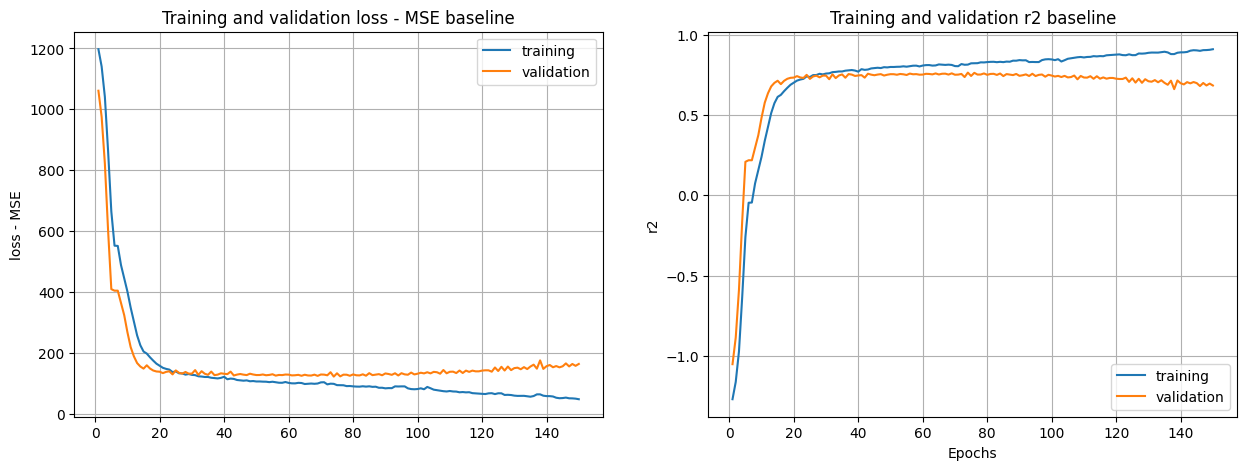

In [21]:
plot_history(mlpbl_hist,'baseline',150)

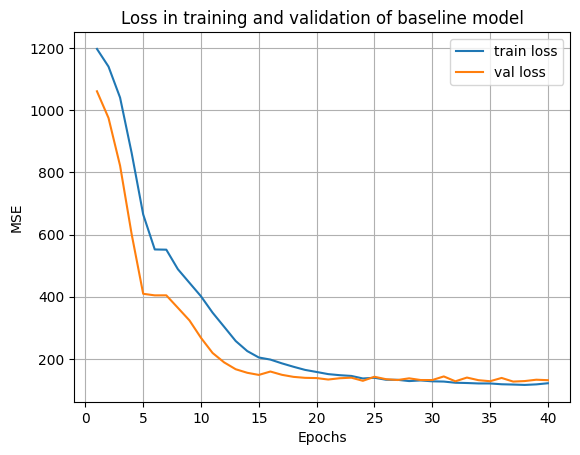

In [22]:
loss_train = mlpbl_hist.history['loss']
loss_val = mlpbl_hist.history['val_loss']


plot_comparation(data_list=[loss_train,loss_val], 
               label_list=['train loss', 'val loss'],
               title='Loss in training and validation of baseline model',
               ylabel='MSE',
               epochrange=(0,40))

In [23]:
get_best_epochs(mlpbl_hist)

Best number of epochs 74


### choose batch size

In [24]:
# default params as baseline

# Grid params
batch_size = np.array([8, 16, 32, 64, 128])
epochs = np.arange(0,30)
batch_pams = dict(batch_size=batch_size, epochs=epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)

mlp = KerasRegressor(model=create_mlpbl, verbose=0)
grid_batch = GridSearchCV(mlp, batch_pams, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_batch = grid_batch.fit(xtrain, ytrain)
summaryGridresult(grid_result_batch, 'Top batch-sizes by ep/ochs', 10)


c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top batch-sizes by ep/ochs
Best: 0.700317 using {'batch_size': 16, 'epochs': 24}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
54,"{'batch_size': 16, 'epochs': 24}",0.801566,0.025505,0.700317,0.025505
49,"{'batch_size': 16, 'epochs': 19}",0.788503,0.033390,0.700006,0.033390
43,"{'batch_size': 16, 'epochs': 13}",0.786320,0.025895,0.698925,0.025895
53,"{'batch_size': 16, 'epochs': 23}",0.802031,0.028619,0.696800,0.028619
14,"{'batch_size': 8, 'epochs': 14}",0.788044,0.034924,0.693942,0.034924
85,"{'batch_size': 32, 'epochs': 25}",0.792834,0.031753,0.692527,0.031753
81,"{'batch_size': 32, 'epochs': 21}",0.785846,0.030553,0.692161,0.030553
55,"{'batch_size': 16, 'epochs': 25}",0.796094,0.035654,0.690191,0.035654
46,"{'batch_size': 16, 'epochs': 16}",0.791310,0.026316,0.689919,0.026316
50,"{'batch_size': 16, 'epochs': 20}",0.800068,0.052690,0.687401,0.052690


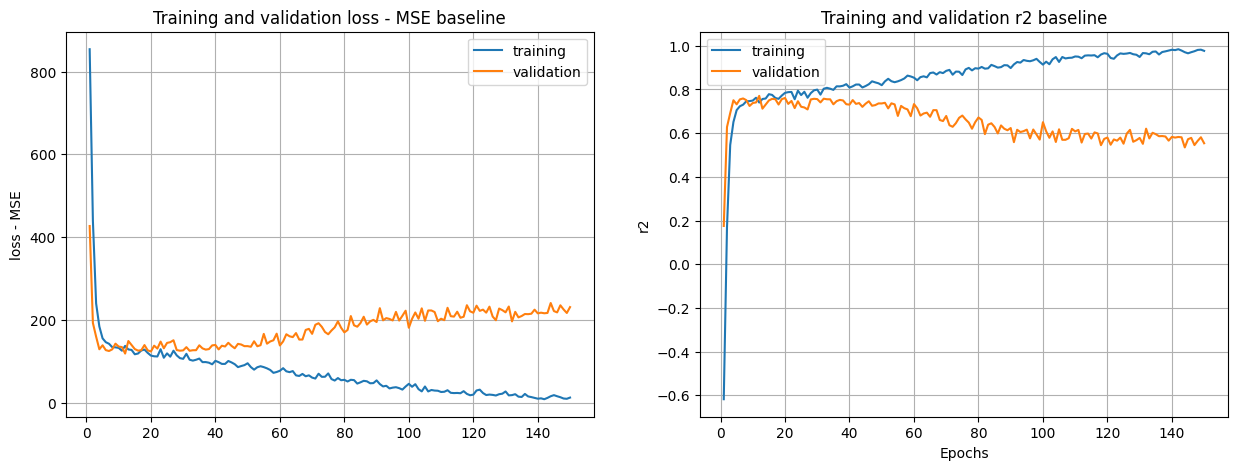

In [25]:
chosenBatch = grid_result_batch.best_params_['batch_size']
tf.random.set_seed(seed)
random.seed(seed)
mlp = create_mlpbl()
mlpbl_hist = mlp.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlpbl_hist,'baseline',150)

In [26]:
get_best_epochs(mlpbl_hist)

Best number of epochs 12


### Kernel initializer

In [27]:
### Kernel initializer

def create_mlpk(k_init = 'uniform'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = k_init, 
                  activation='relu', input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = 'relu'))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
k_init = ['uniform', 'normal', 'glorot_normal', 'glorot_uniform',]
epochs = np.arange(0,30)

pams_grid = dict(model__k_init= k_init,  
               epochs = epochs)

# Build model and grid searcg
random.seed(seed)
tf.random.set_seed(seed)
mlp = KerasRegressor(model = create_mlpk,
                     batch_size = chosenBatch,
                     verbose=0)
grid_kn = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_kn = grid_kn.fit(xtrain, ytrain)


pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_kn, 'Top results for inititalization' , 10)


Top results for inititalization
Best: 0.697621 using {'epochs': 21, 'model__k_init': 'uniform'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
84,"{'epochs': 21, 'model__k_init': 'uniform'}",0.790533,0.022077,0.697621,0.022077
100,"{'epochs': 25, 'model__k_init': 'uniform'}",0.814051,0.032475,0.695040,0.032475
76,"{'epochs': 19, 'model__k_init': 'uniform'}",0.801306,0.041323,0.692943,0.041323
104,"{'epochs': 26, 'model__k_init': 'uniform'}",0.810927,0.025246,0.692612,0.025246
57,"{'epochs': 14, 'model__k_init': 'normal'}",0.785881,0.040723,0.691878,0.040723
82,"{'epochs': 20, 'model__k_init': 'glorot_normal'}",0.815689,0.021925,0.691727,0.021925
77,"{'epochs': 19, 'model__k_init': 'normal'}",0.784528,0.038119,0.691130,0.038119
92,"{'epochs': 23, 'model__k_init': 'uniform'}",0.803473,0.032099,0.689204,0.032099
71,"{'epochs': 17, 'model__k_init': 'glorot_uniform'}",0.802173,0.034783,0.689056,0.034783
86,"{'epochs': 21, 'model__k_init': 'glorot_normal'}",0.826048,0.046550,0.687809,0.046550


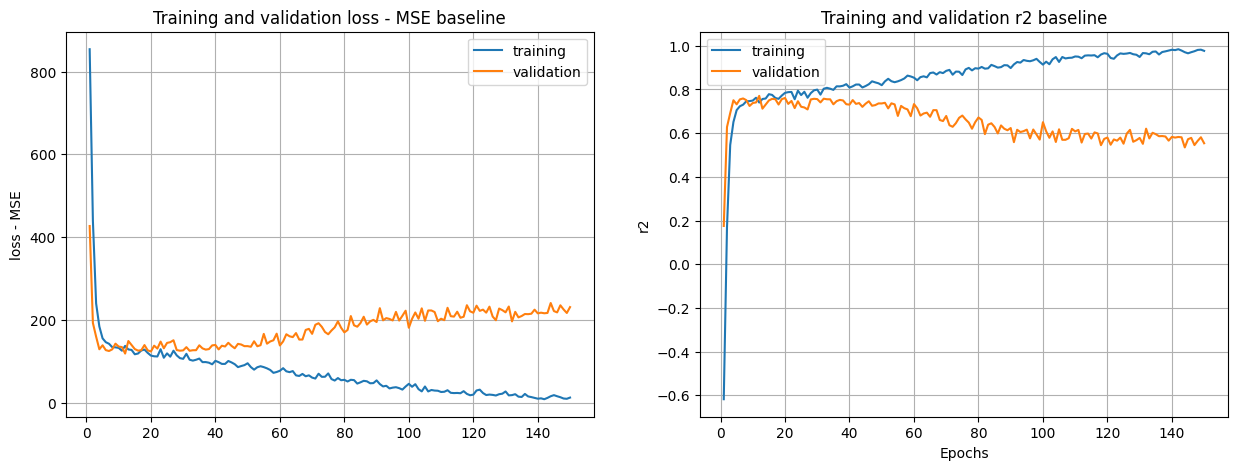

In [28]:
chosenKn = grid_result_kn.best_params_['model__k_init']
tf.random.set_seed(seed)
random.seed(seed)
mlp_kn = create_mlpk(chosenKn)
mlp_kn_hist = mlp_kn.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_kn_hist,'baseline',150)

In [29]:
get_best_epochs(mlp_kn_hist)

Best number of epochs 12


### activation funtion

In [30]:
# model default params for assessing activation and kernel initialization
# network = [256, 128, 64, 16, 8]
# batch size = 128
# opt = 'adam'

def create_mlpa(acti = 'relu'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=acti, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = acti))
   model.add(Dense(1))
   model.compile(optimizer='adam', 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
acti = ['relu','selu','elu', 'tanh', 'sigmoid']
epochs = np.arange(0,30)

pams_grid = dict(model__acti = acti, 
               epochs = epochs)

# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlpa,
                     batch_size = chosenBatch,
                     verbose=0)
grid_a = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_a = grid_a.fit(xtrain, ytrain)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_a, 'Top results for activation' , 10)

Top results for activation
Best: 0.704050 using {'epochs': 27, 'model__acti': 'elu'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
137,"{'epochs': 27, 'model__acti': 'elu'}",0.788357,0.036166,0.704050,0.036166
112,"{'epochs': 22, 'model__acti': 'elu'}",0.773598,0.024165,0.702928,0.024165
147,"{'epochs': 29, 'model__acti': 'elu'}",0.780314,0.027842,0.700047,0.027842
75,"{'epochs': 15, 'model__acti': 'relu'}",0.795695,0.031530,0.699937,0.031530
107,"{'epochs': 21, 'model__acti': 'elu'}",0.772919,0.034338,0.699379,0.034338
117,"{'epochs': 23, 'model__acti': 'elu'}",0.776835,0.037190,0.696246,0.037190
125,"{'epochs': 25, 'model__acti': 'relu'}",0.802693,0.032789,0.695488,0.032789
102,"{'epochs': 20, 'model__acti': 'elu'}",0.776808,0.049676,0.693630,0.049676
135,"{'epochs': 27, 'model__acti': 'relu'}",0.808696,0.035664,0.691574,0.035664
145,"{'epochs': 29, 'model__acti': 'relu'}",0.826194,0.042194,0.691497,0.042194


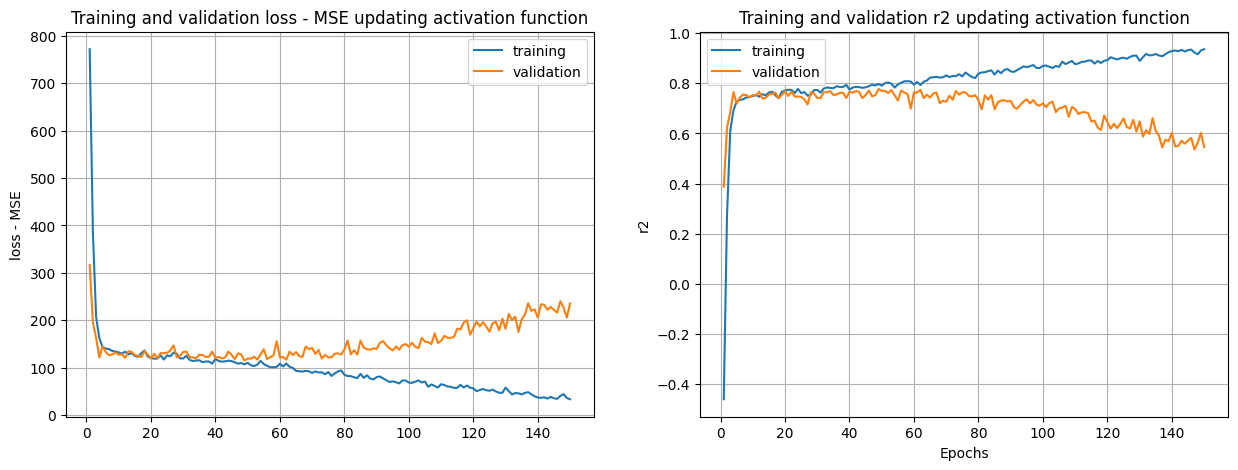

In [31]:
chosenActi = grid_result_a.best_params_['model__acti']
tf.random.set_seed(seed)
random.seed(seed)
mlp_a = create_mlpa(chosenActi)
mlp_a_hist = mlp_a.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)
plot_history(mlp_a_hist,'updating activation function',150)

In [32]:
get_best_epochs(mlp_a_hist)

Best number of epochs 49


### Selecting optimizer

In [33]:
# model default params for assessing optimization
# network = [256, 128, 64, 16]
# batch size = 128
# acti = 'selu' / kernel_init = 'uniform' 
def create_mlpopt(opt = 'Adam'):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=opt, 
               loss='mse', metrics=[RSquare()])
   return model

# Grid params
opt = ['SGD', 'RMSprop', 'Adam']
epochs = np.arange(0,30)
pams_grid = dict(model__opt =opt, 
                  epochs = epochs)

# Build model and grid searcg
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model=create_mlpopt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_opt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_opt = grid_opt.fit(xtrain, ytrain)
summaryGridresult(grid_result_opt, 'Top resutls for optimizer' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-1.51561493 -1.54561495 -1.54522977         nan  0.36325419  0.4447144
         nan  0.62247842  0.63112778         nan  0.54844903  0.65508553
         nan  0.56541748  0.63818756         nan  0.6722161   0.64935025
         nan  0.64596918  0.65529182         nan  0.58720025  0.60614841
         nan  0.65294411  0.6574725          nan  0.62068869  0.63134985
         nan  0.64171412  0.66163566         nan  0.65435145  0.68712967
         nan  0.59099085  0.66050064         nan  0.67816406  0.65294729
         nan  0.6769653   0.65

Top resutls for optimizer
Best: 0.698809 using {'epochs': 22, 'model__opt': 'Adam'}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
68,"{'epochs': 22, 'model__opt': 'Adam'}",0.761299,0.029587,0.698809,0.029587
80,"{'epochs': 26, 'model__opt': 'Adam'}",0.781173,0.023606,0.696567,0.023606
83,"{'epochs': 27, 'model__opt': 'Adam'}",0.781179,0.036476,0.692686,0.036476
64,"{'epochs': 21, 'model__opt': 'RMSprop'}",0.745304,0.037329,0.688025,0.037329
35,"{'epochs': 11, 'model__opt': 'Adam'}",0.745934,0.024499,0.687130,0.024499
74,"{'epochs': 24, 'model__opt': 'Adam'}",0.774165,0.041167,0.686886,0.041167
65,"{'epochs': 21, 'model__opt': 'Adam'}",0.764821,0.037073,0.681050,0.037073
89,"{'epochs': 29, 'model__opt': 'Adam'}",0.798630,0.042539,0.680976,0.042539
62,"{'epochs': 20, 'model__opt': 'Adam'}",0.774188,0.023956,0.679102,0.023956
85,"{'epochs': 28, 'model__opt': 'RMSprop'}",0.773049,0.043702,0.679005,0.043702


#### Learning rate

In [34]:
chosenOpt = grid_result_opt.best_params_['model__opt']

def create_mlplr():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   model.compile(optimizer=chosenOpt, 
               loss='mse', metrics=[RSquare()])
   return model

lr = [0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075]
epochs = np.arange(0,30)
pams_grid = dict(model__optimizer__learning_rate=lr,
                  epochs = epochs)


# Build model and grid search
tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model = create_mlplr,
                     batch_size = chosenBatch,
                     verbose=0)
grid_lr = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1,)
                        
grid_result_lr = grid_lr.fit(xtrain, ytrain)

pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_lr, 'Top results for learning rate' , 10)

c:\Users\Eigenaar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Top results for learning rate
Best: 0.707777 using {'epochs': 22, 'model__optimizer__learning_rate': 0.0005}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
155,"{'epochs': 22, 'model__optimizer__learning_rate': 0.0005}",0.772639,0.033945,0.707777,0.033945
140,"{'epochs': 20, 'model__optimizer__learning_rate': 0.00025}",0.767812,0.026685,0.705133,0.026685
187,"{'epochs': 26, 'model__optimizer__learning_rate': 0.005}",0.785729,0.028017,0.703450,0.028017
160,"{'epochs': 22, 'model__optimizer__learning_rate': 0.0075}",0.783040,0.028828,0.703419,0.028828
195,"{'epochs': 27, 'model__optimizer__learning_rate': 0.0075}",0.777060,0.040626,0.702880,0.040626
174,"{'epochs': 24, 'model__optimizer__learning_rate': 0.0075}",0.782041,0.030984,0.702374,0.030984
200,"{'epochs': 28, 'model__optimizer__learning_rate': 0.0025}",0.788550,0.034051,0.702223,0.034051
113,"{'epochs': 16, 'model__optimizer__learning_rate': 0.0005}",0.759620,0.029949,0.701135,0.029949
203,"{'epochs': 29, 'model__optimizer__learning_rate': 0.00025}",0.781988,0.041599,0.700922,0.041599
158,"{'epochs': 22, 'model__optimizer__learning_rate': 0.0025}",0.780584,0.038541,0.700267,0.038541


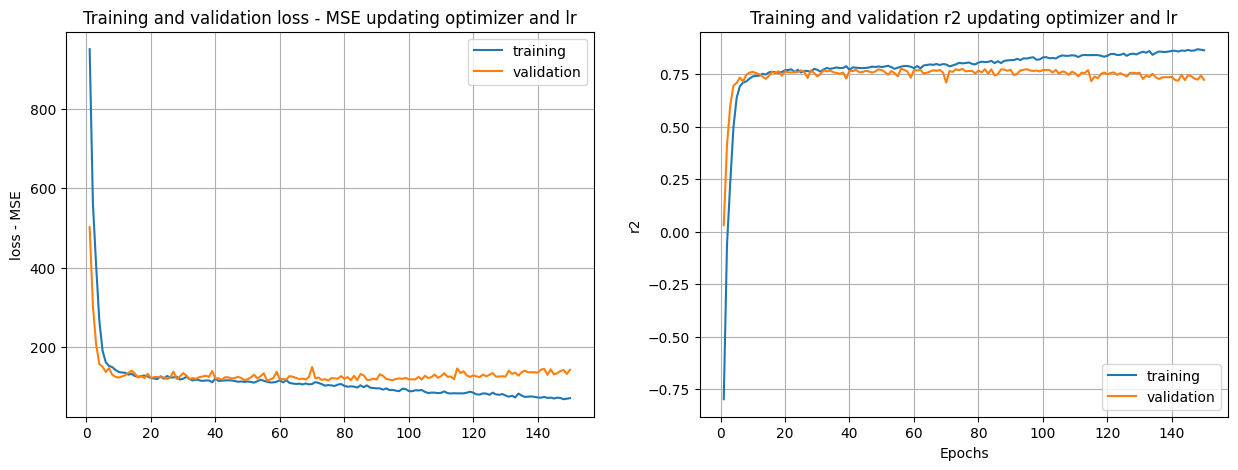

In [35]:
# visualize
chosenLr = grid_result_lr.best_params_['model__optimizer__learning_rate']
def create_mlplr():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   for l in network[1:]: 
      model.add(Dense(l, activation = chosenActi))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate = chosenLr)
   model.compile(optimizer=opt, 
               loss='mse', metrics=[RSquare()])
   return model

tf.random.set_seed(seed)
random.seed(seed)
mlp_lr =  create_mlplr()
mlp_lr_hist= mlp_lr.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)

plot_history(mlp_lr_hist,'updating optimizer and lr',150)


In [36]:
get_best_epochs(mlp_lr_hist)

Best number of epochs 56


### Drop-out

In [37]:
# Drop oout
def create_mlpdpt(dpt = 0):
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   model.add(Dropout(dpt))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
      model.add(Dropout(dpt))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate=chosenLr)
   model.compile(optimizer = opt, 
               loss='mse', metrics=[RSquare()])
   return model
#Buil Learning rate for optimization function
dpt = [0, 0.1,0.2, 0.3, 0.4, 0.5]
epochs = np.arange(0,30)

pams_grid = dict(model__dpt=dpt,
                  epochs = epochs)

# Build model and grid searcg

tf.random.set_seed(seed)
random.seed(seed)
mlp = KerasRegressor(model=create_mlpdpt,
                     batch_size = chosenBatch,
                     verbose=0)
grid_dpt = GridSearchCV(mlp, pams_grid, cv = 4, 
                        return_train_score=True,
                        n_jobs = -1)
grid_result_dpt = grid_dpt.fit(xtrain, ytrain)
pd.set_option('max_colwidth', 80)
summaryGridresult(grid_result_dpt, 'Top results for drop-put rate' , 10)

Top results for drop-put rate
Best: 0.702706 using {'epochs': 28, 'model__dpt': 0.1}


,params,mean_train_score,std_test_score,mean_test_score,std_test_score
169,"{'epochs': 28, 'model__dpt': 0.1}",0.760032,0.032876,0.702706,0.032876
121,"{'epochs': 20, 'model__dpt': 0.1}",0.762796,0.019687,0.699574,0.019687
174,"{'epochs': 29, 'model__dpt': 0}",0.768669,0.031306,0.699222,0.031306
146,"{'epochs': 24, 'model__dpt': 0.2}",0.748806,0.029796,0.698415,0.029796
139,"{'epochs': 23, 'model__dpt': 0.1}",0.768767,0.022737,0.696895,0.022737
168,"{'epochs': 28, 'model__dpt': 0}",0.781714,0.031590,0.696798,0.031590
157,"{'epochs': 26, 'model__dpt': 0.1}",0.765753,0.033205,0.694437,0.033205
126,"{'epochs': 21, 'model__dpt': 0}",0.769273,0.037119,0.693780,0.037119
163,"{'epochs': 27, 'model__dpt': 0.1}",0.766205,0.028272,0.693662,0.028272
127,"{'epochs': 21, 'model__dpt': 0.1}",0.759065,0.027244,0.693541,0.027244


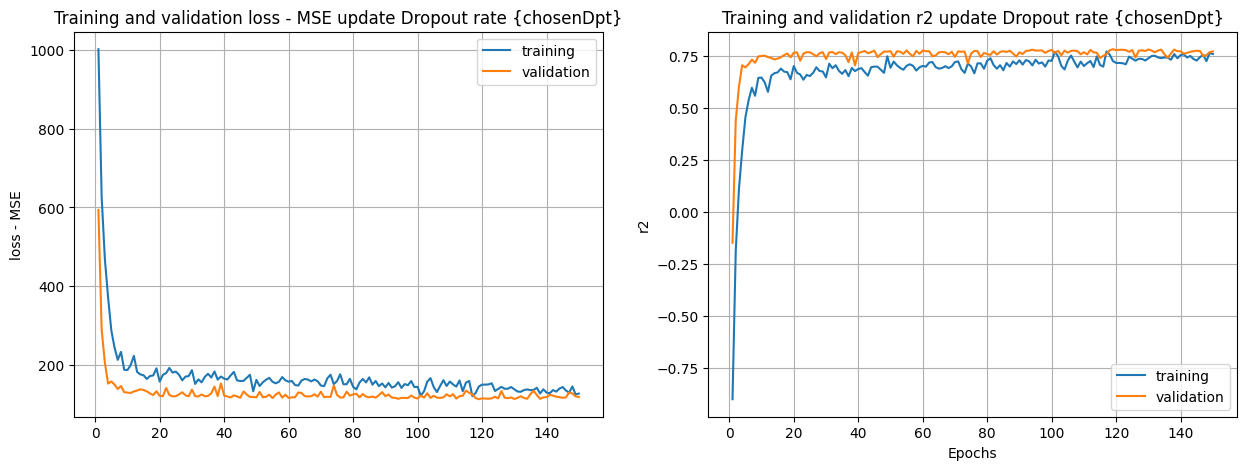

In [38]:
# Visualize
chosenDpt = grid_result_dpt.best_params_['model__dpt']
tf.random.set_seed(seed)
random.seed(seed)
mlp_dpt =  create_mlpdpt(chosenDpt)
mlp_dpt_hist= mlp_dpt.fit(xtrain_,ytrain_,
                      epochs=150,
                      batch_size=chosenBatch,
                      validation_data=(xval_, yval_),
                      verbose=0)

plot_history(mlp_dpt_hist,'update Dropout rate {chosenDpt}',150)


### Final model

In [39]:
def create_mlp():
   network = chosenNetwork
   model = Sequential()
   model.add(Dense(network[0], kernel_initializer = chosenKn, 
                  activation=chosenActi, input_shape =(n_feat,) ))
   model.add(Dropout(chosenDpt))
   for l in network[1:]: 
      model.add(Dense(l, activation =chosenActi))
      model.add(Dropout(chosenDpt))
   model.add(Dense(1))
   opt = tf.keras.optimizers.Adam(learning_rate=chosenLr)
   model.compile(optimizer = opt, 
               loss='mse', metrics=[RSquare()])
   return model

In [46]:
chosenEp = grid_result_dpt.best_params_['epochs']
tf.random.set_seed(seed)
random.seed(seed)
mlp_final = create_mlp()
mlp_final.fit(xtrain, ytrain,
               epochs=chosenEp,
               batch_size=chosenBatch,
               verbose=0,)


In [47]:
test_lost_score, test_r2_score = mlp_final.evaluate(xtest, ytest)
test_pred = mlp_final.predict(xtest)

4/4 [==============================] - 0s 1ms/step


MSE in testing: 144.0242462158203, 
R2 in testing: 0.7372034788131714,
MAE in testing: 8.377317018371363, 
Precision of 10%: 0.4519230769230769


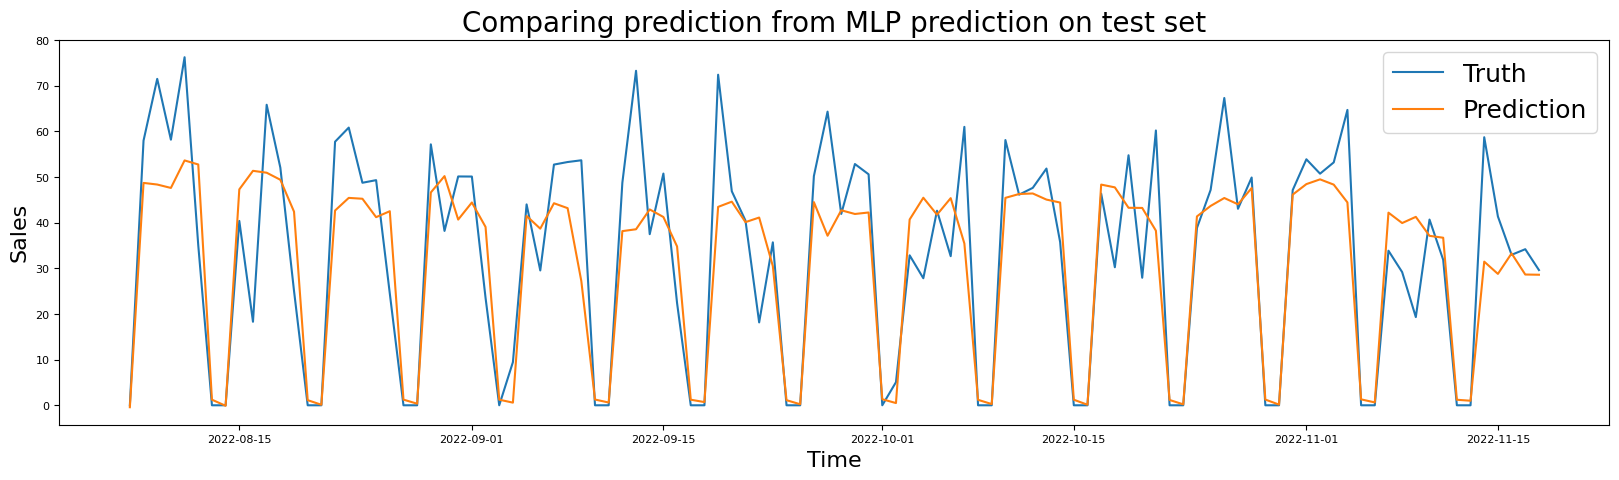

In [48]:

mae =  mean_absolute_error(ytest, test_pred)
pre = get_pre(ytest, test_pred, 0.1)

print(f'MSE in testing: {test_lost_score}, \nR2 in testing: {test_r2_score},\nMAE in testing: {mae}, \nPrecision of 10%: {pre}')

plotprediction(ytest_df, test_pred.flatten(), 'MLP prediction on test set')